In [6]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from pathlib import Path
import glob

Found 3 .npy files in train:
  - train/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data20.npy
  - train/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data20_gt.npy
  - train/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data10.npy

Visualizing first 3 files...

File 1: train/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data20.npy
Loaded train/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data20.npy: shape (8000, 6, 32, 32)


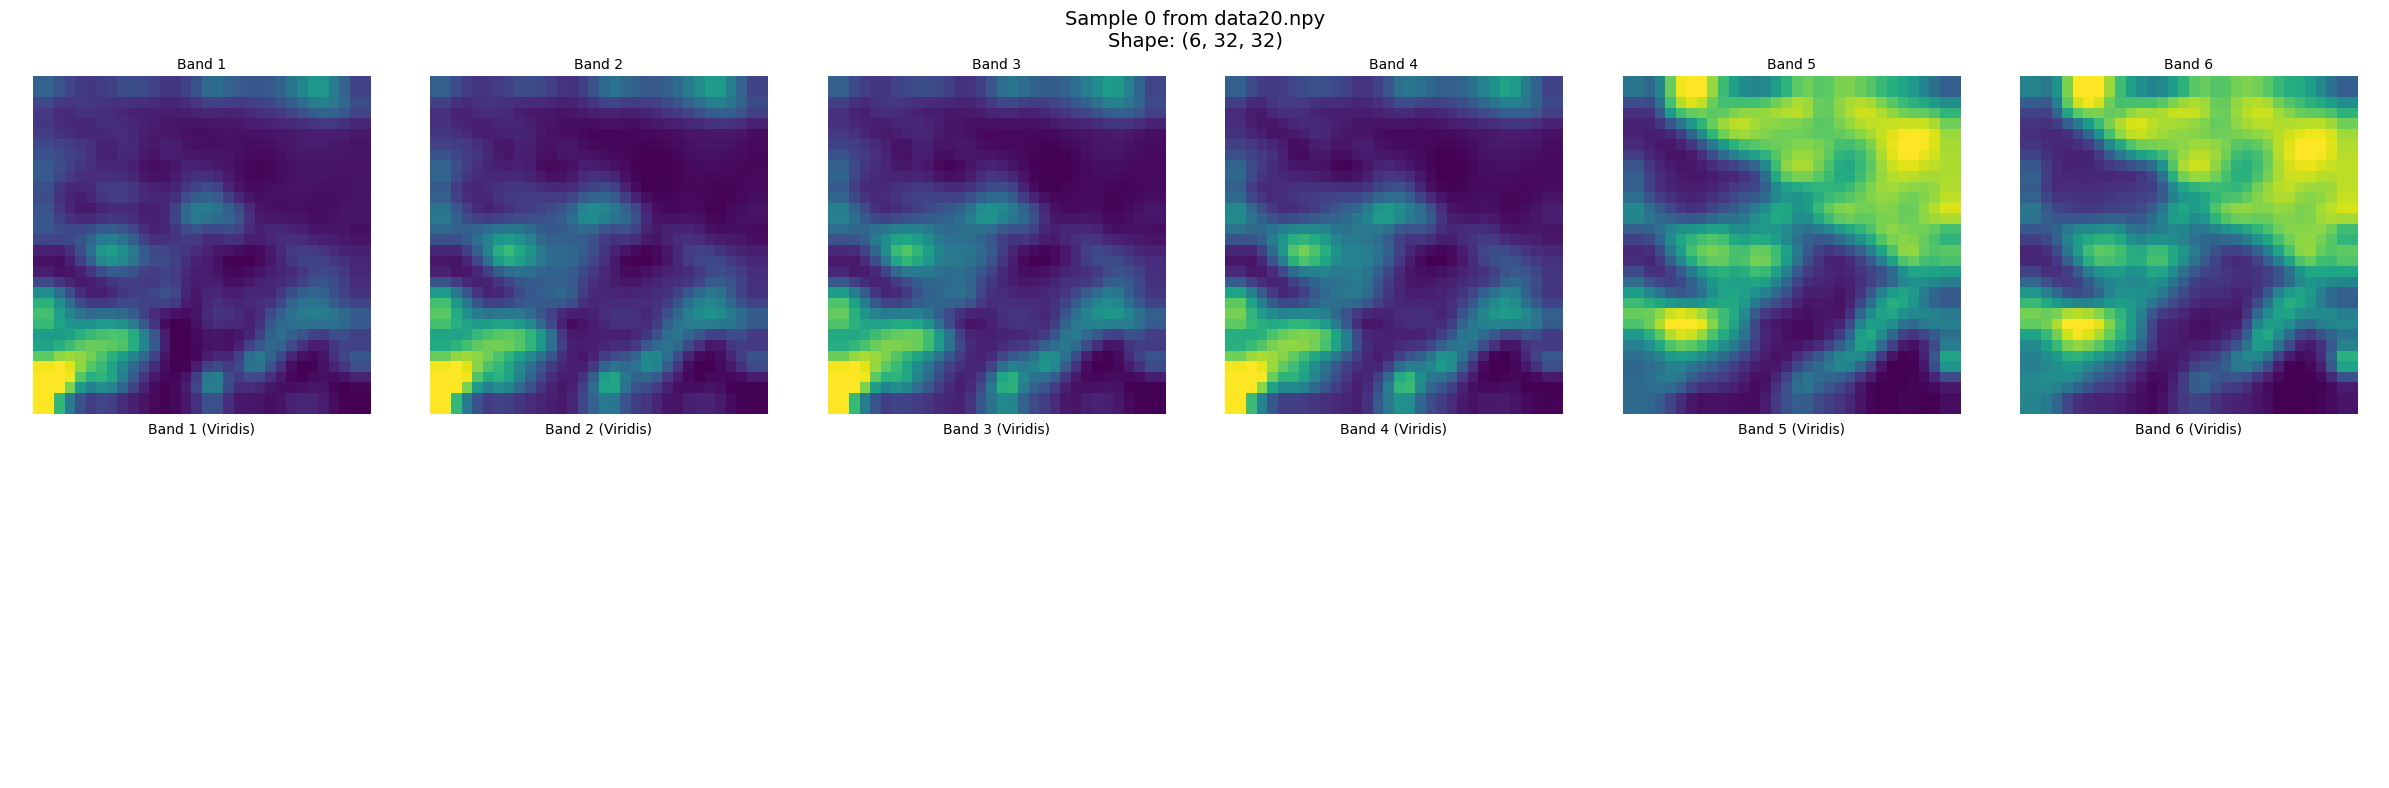


Statistics for sample 0:
Band 1: min=1547.31, max=9471.77, mean=2829.21, std=1185.12
Band 2: min=1771.25, max=9368.69, mean=3150.27, std=1214.57
Band 3: min=1795.44, max=9096.56, mean=3229.07, std=1204.65
Band 4: min=1791.28, max=8897.86, mean=3288.59, std=1211.37
Band 5: min=1206.14, max=2802.75, mean=1902.57, std=413.12
Band 6: min=1136.78, max=2391.83, mean=1677.14, std=324.04

File 2: train/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data20_gt.npy
Loaded train/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data20_gt.npy: shape (8000, 6, 32, 32)


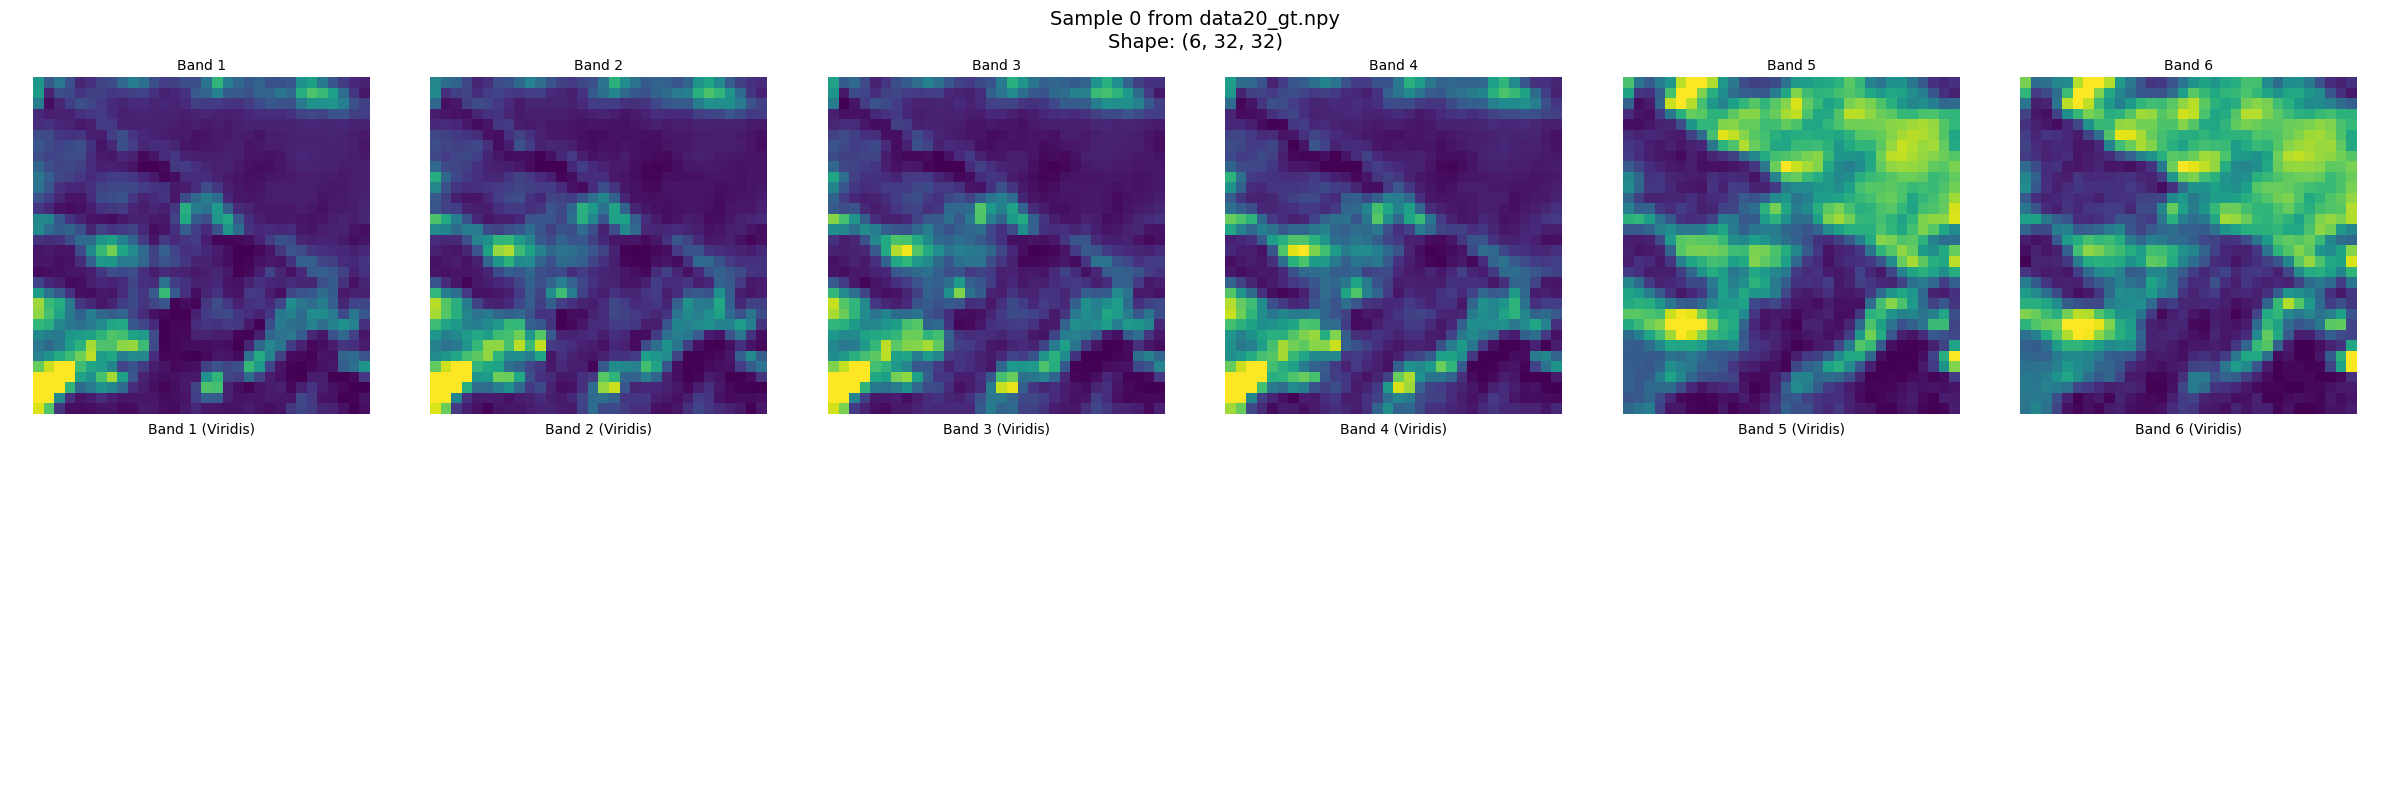


Statistics for sample 0:
Band 1: min=1200.00, max=11591.00, mean=2832.09, std=1528.72
Band 2: min=1307.00, max=11346.00, mean=3153.43, std=1557.94
Band 3: min=1348.00, max=11071.00, mean=3231.84, std=1537.34
Band 4: min=1305.00, max=10678.00, mean=3291.06, std=1547.70
Band 5: min=1114.00, max=3361.00, mean=1900.85, std=493.12
Band 6: min=1085.00, max=2876.00, mean=1676.16, std=386.15

File 3: train/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data10.npy
Loaded train/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data10.npy: shape (8000, 4, 32, 32)


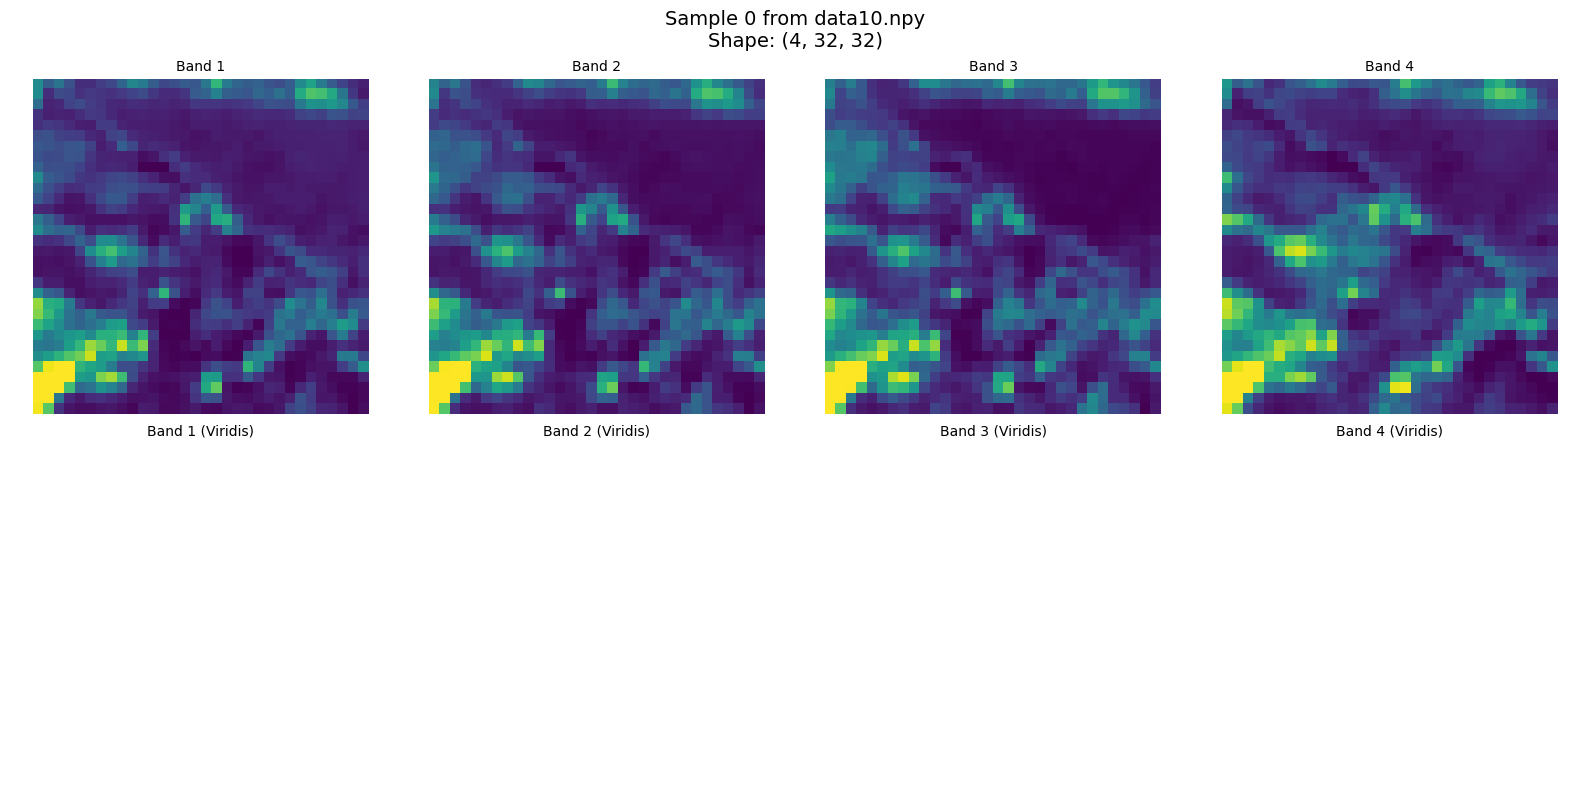


Statistics for sample 0:
Band 1: min=1178.50, max=10820.50, mean=2618.79, std=1389.69
Band 2: min=1176.50, max=10521.25, mean=2605.06, std=1376.89
Band 3: min=1051.25, max=10409.25, mean=2590.52, std=1459.64
Band 4: min=1508.50, max=10732.25, mean=3270.52, std=1516.45

Comparing files side by side...
Loaded train/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data20.npy: shape (8000, 6, 32, 32)
Loaded train/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data20_gt.npy: shape (8000, 6, 32, 32)
Loaded train/S2A_MSIL2A_20170102T093402_N0500_R136_T34TDK_20230926T223643.SAFE/data10.npy: shape (8000, 4, 32, 32)


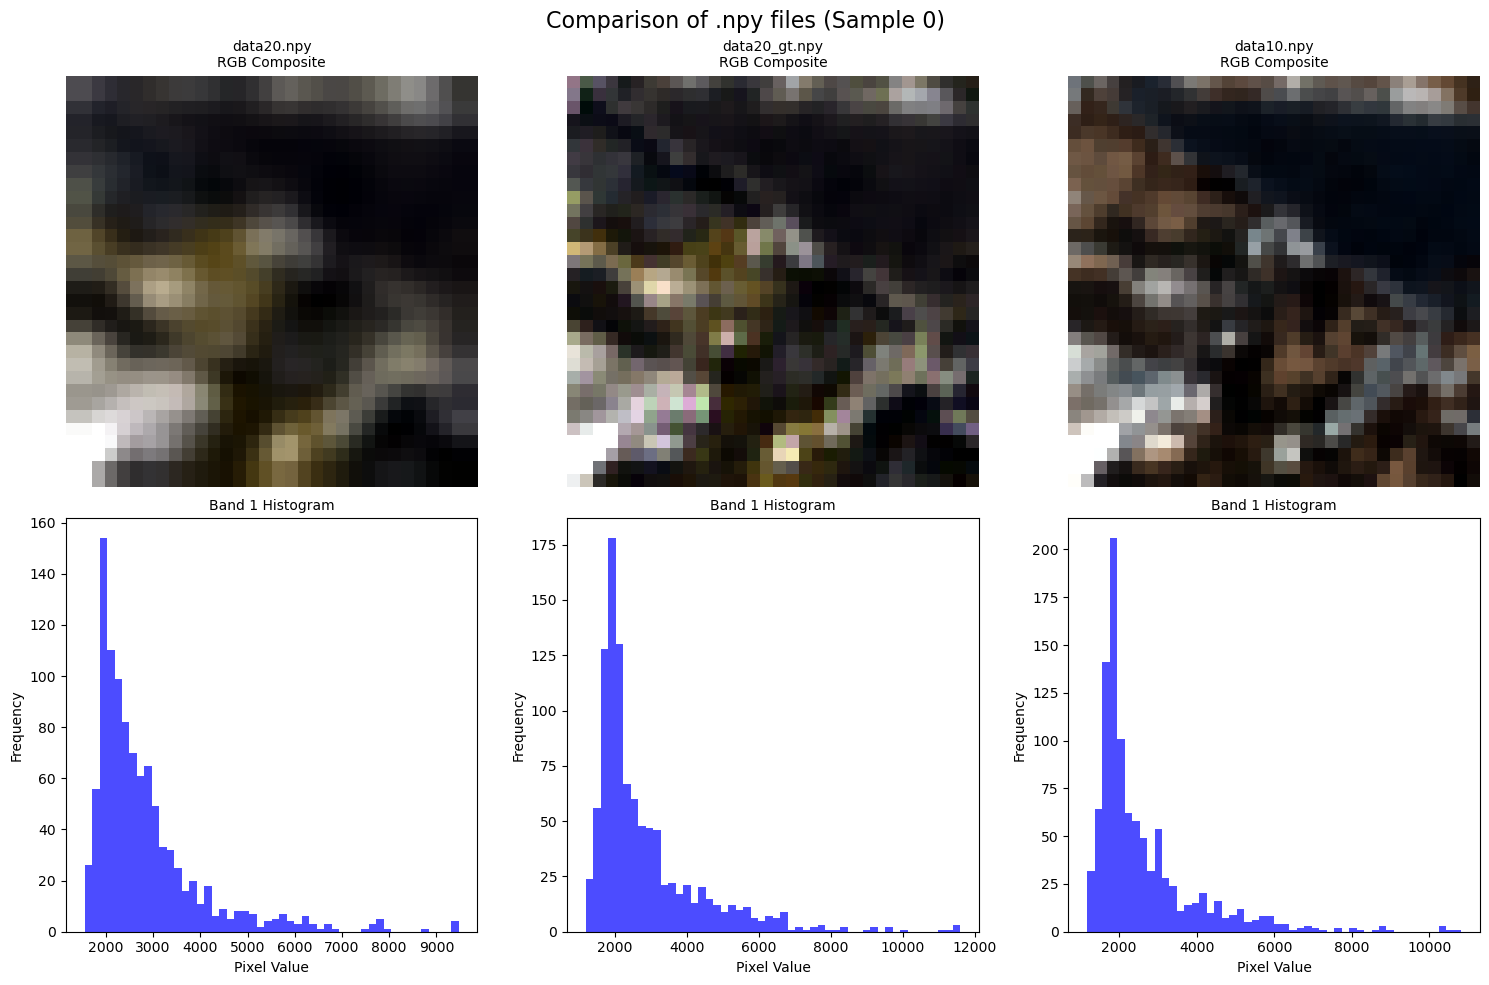

In [8]:
def load_npy_data(filename):
    """Load .npy data with format [number of images, channels, w, h]"""
    try:
        data = np.load(filename)
        print(f"Loaded {filename}: shape {data.shape}")
        return data
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None

def normalize_band(band_data):
    """Normalize image data using percentile clipping"""
    if band_data is None or band_data.size == 0:
        return band_data
    
    # Clip to 1st and 99th percentiles to handle outliers
    p1, p99 = np.percentile(band_data, (1, 99))
    normalized = np.clip(band_data, p1, p99)
    
    # Normalize to [0, 1]
    if p99 > p1:
        normalized = (normalized - p1) / (p99 - p1)
    
    return normalized

def visualize_npy_sample(data, sample_idx=0, filename="", max_bands=6):
    """Visualize a single sample from .npy data"""
    if data is None or len(data.shape) != 4:
        print("Invalid data format. Expected [images, channels, w, h]")
        return
    
    if sample_idx >= data.shape[0]:
        print(f"Sample index {sample_idx} out of range. Data has {data.shape[0]} samples")
        return
    
    sample = data[sample_idx]  # Shape: [channels, w, h]
    num_bands = min(sample.shape[0], max_bands)
    
    # Create subplot grid
    fig, axes = plt.subplots(2, num_bands, figsize=(4*num_bands, 8))
    if num_bands == 1:
        axes = axes.reshape(2, 1)
    
    fig.suptitle(f'Sample {sample_idx} from {filename}\nShape: {sample.shape}', fontsize=14)
    
    for i in range(num_bands):
        band_data = sample[i]  # Shape: [w, h]
        normalized = normalize_band(band_data)
        
        # Top row: grayscale
        im1 = axes[0, i].imshow(normalized, cmap='gray')
        axes[0, i].set_title(f'Band {i+1}', fontsize=10)
        axes[0, i].axis('off')
        
        # Bottom row: viridis colormap
        im2 = axes[0, i].imshow(normalized, cmap='viridis')
        axes[1, i].set_title(f'Band {i+1} (Viridis)', fontsize=10)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nStatistics for sample {sample_idx}:")
    for i in range(num_bands):
        band_data = sample[i]
        print(f"Band {i+1}: min={band_data.min():.2f}, max={band_data.max():.2f}, "
              f"mean={band_data.mean():.2f}, std={band_data.std():.2f}")

def compare_npy_samples(filenames, max_files=3, sample_idx=0):
    """Compare multiple .npy files side by side"""
    if not filenames:
        print("No files provided")
        return
    
    files_to_show = filenames[:max_files]
    num_files = len(files_to_show)
    
    fig, axes = plt.subplots(2, num_files, figsize=(5*num_files, 10))
    if num_files == 1:
        axes = axes.reshape(2, 1)
    
    fig.suptitle(f'Comparison of .npy files (Sample {sample_idx})', fontsize=16)
    
    for i, filename in enumerate(files_to_show):
        data = load_npy_data(filename)
        if data is not None and sample_idx < data.shape[0]:
            sample = data[sample_idx]
            num_bands = min(sample.shape[0], 3)  # Show first 3 bands
            
            # Create RGB composite if we have at least 3 bands
            if num_bands >= 3:
                height, width = sample.shape[1], sample.shape[2]
                rgb = np.zeros((height, width, 3))
                rgb[:, :, 0] = normalize_band(sample[2])  # Red
                rgb[:, :, 1] = normalize_band(sample[1])  # Green
                rgb[:, :, 2] = normalize_band(sample[0])  # Blue
                
                axes[0, i].imshow(rgb)
                axes[0, i].set_title(f'{os.path.basename(filename)}\nRGB Composite', fontsize=10)
            else:
                # Show first band in grayscale
                normalized = normalize_band(sample[0])
                axes[0, i].imshow(normalized, cmap='gray')
                axes[0, i].set_title(f'{os.path.basename(filename)}\nBand 1', fontsize=10)
            
            axes[0, i].axis('off')
            
            # Show histogram of first band
            if num_bands > 0:
                band_data = sample[0].flatten()
                axes[1, i].hist(band_data, bins=50, alpha=0.7, color='blue')
                axes[1, i].set_title(f'Band 1 Histogram', fontsize=10)
                axes[1, i].set_xlabel('Pixel Value')
                axes[1, i].set_ylabel('Frequency')
        else:
            axes[0, i].text(0.5, 0.5, f'Failed to load\n{os.path.basename(filename)}', 
                           ha='center', va='center', transform=axes[0, i].transAxes)
            axes[0, i].axis('off')
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Find all .npy files in train60 directory
train60_path = "train"
if os.path.exists(train60_path):
    npy_files = glob.glob(os.path.join(train60_path, "**/*.npy"), recursive=True)
    print(f"Found {len(npy_files)} .npy files in {train60_path}:")
    for file in npy_files:
        print(f"  - {file}")
    
    # Visualize first few files
    if npy_files:
        print(f"\nVisualizing first {min(3, len(npy_files))} files...")
        for i, file in enumerate(npy_files[:3]):
            print(f"\n{'='*50}")
            print(f"File {i+1}: {file}")
            print('='*50)
            
            data = load_npy_data(file)
            if data is not None:
                visualize_npy_sample(data, sample_idx=0, filename=os.path.basename(file))
        
        # Compare files side by side
        print(f"\n{'='*50}")
        print("Comparing files side by side...")
        print('='*50)
        compare_npy_samples(npy_files[:3], max_files=3, sample_idx=0)
    else:
        print("No .npy files found in train60 directory")
else:
    print(f"Directory {train60_path} not found. Please check the path.")
